In [67]:
# IRkernel::installspec(user = FALSE)|

In [1]:
library(RColorBrewer)
library(readxl)
library(ggplot2)
library(dplyr)


다음의 패키지를 부착합니다: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




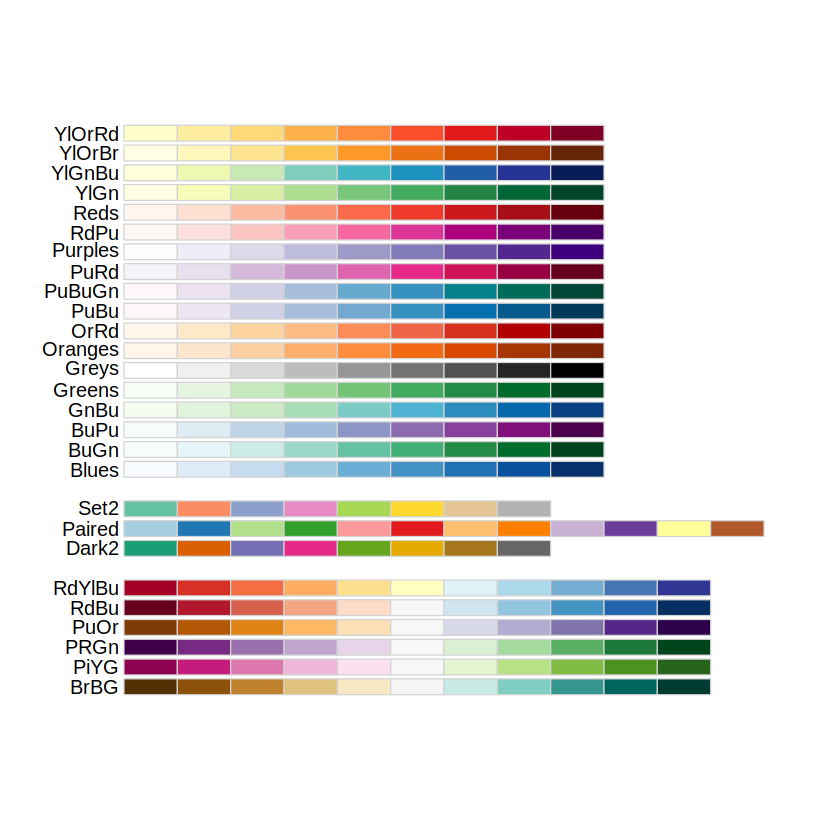

In [2]:
display.brewer.all(colorblindFriendly = TRUE)

In [3]:
# display.brewer.pal(n = 8, name = 'Dark2')
color_map_use = c(RColorBrewer::brewer.pal(8, "Dark2"))
color_map_use = c("#2A363B", "#355C7D", "#99B898", "#E84A5F", "#FF847C", "#FECEAB")

### Common: read data excel

In [4]:
df_original = read_excel("/home/jinhyun/codes/geography_prediction/results/Geography prediction experiments.xlsx", sheet = "from_43M")

In [5]:
names(df_original)

[1] "random_seed"                 "pre_select_method"          
 [3] "n_pre_select"                "n_pre_select_goal"          
 [5] "select_method"               "select_n"                   
 [7] "n_dim_reduced"               "train_model"                
 [9] "hyper_params"                "model_params"               
[11] "preselect_cpu_time"          "preselect_wall_time"        
[13] "preselect_memory_usage"      "select_cpu_time"            
[15] "select_wall_time"            "select_memory_usage"        
[17] "train_cpu_time"              "train_wall_time"            
[19] "train_memory_usage"          "testset_accuracy"           
[21] "testset_f1_micro"            "testset_f1_macro"           
[23] "testset_f1_weighted"         "testset_class_BEB_accuracy" 
[25] "testset_class_CDX_accuracy"  "testset_class_CEU_accuracy" 
[27] "testset_class_CHS_accuracy"  "testset_class_CLM_accuracy" 
[29] "testset_class_ESN_accuracy"  "testset_class_FIN_accuracy" 
[31] "testset_class_GWD_accuracy"  "testset_class_IBS_accuracy" 
[33] "testset_class_JPT_accuracy"  "testset_class_KHV_accuracy" 
[35] "testset_class_LWK_accuracy"  "testset_class_MSL_accuracy" 
[37] "testset_class_MXL_accuracy"  "testset_class_PEL_accuracy" 
[39] "testset_class_PJL_accuracy"  "testset_class_PUR_accuracy" 
[41] "testset_class_TSI_accuracy"  "testset_class_YRI_accuracy" 
[43] "valset_accuracy"             "valset_f1_micro"            
[45] "valset_f1_macro"             "valset_f1_weighted"         
[47] "valset_class_BEB_accuracy"   "valset_class_CDX_accuracy"  
[49] "valset_class_CEU_accuracy"   "valset_class_CHS_accuracy"  
[51] "valset_class_CLM_accuracy"   "valset_class_ESN_accuracy"  
[53] "valset_class_FIN_accuracy"   "valset_class_GWD_accuracy"  
[55] "valset_class_IBS_accuracy"   "valset_class_JPT_accuracy"  
[57] "valset_class_KHV_accuracy"   "valset_class_LWK_accuracy"  
[59] "valset_class_MSL_accuracy"   "valset_class_MXL_accuracy"  
[61] "valset_class_PEL_accuracy"   "valset_class_PJL_accuracy"  
[63] "valset_class_PUR_accuracy"   "valset_class_TSI_accuracy"  
[65] "valset_class_YRI_accuracy"   "trainset_accuracy"          
[67] "trainset_f1_micro"           "trainset_f1_macro"          
[69] "trainset_f1_weighted"        "trainset_class_BEB_accuracy"
[71] "trainset_class_CDX_accuracy" "trainset_class_CEU_accuracy"
[73] "trainset_class_CHS_accuracy" "trainset_class_CLM_accuracy"
[75] "trainset_class_ESN_accuracy" "trainset_class_FIN_accuracy"
[77] "trainset_class_GWD_accuracy" "trainset_class_IBS_accuracy"
[79] "trainset_class_JPT_accuracy" "trainset_class_KHV_accuracy"
[81] "trainset_class_LWK_accuracy" "trainset_class_MSL_accuracy"
[83] "trainset_class_MXL_accuracy" "trainset_class_PEL_accuracy"
[85] "trainset_class_PJL_accuracy" "trainset_class_PUR_accuracy"
[87] "trainset_class_TSI_accuracy" "trainset_class_YRI_accuracy"

In [6]:
df = df_original %>% 
  mutate(plot_unit = interaction(random_seed, pre_select_method,	n_pre_select,	n_pre_select_goal, select_method, train_model),
         select_method = factor(select_method, c("random","xgb", "rf", "variance", "chi2", "f_classif"))) 

### Figure 2. Accuracy by n_select and selection method

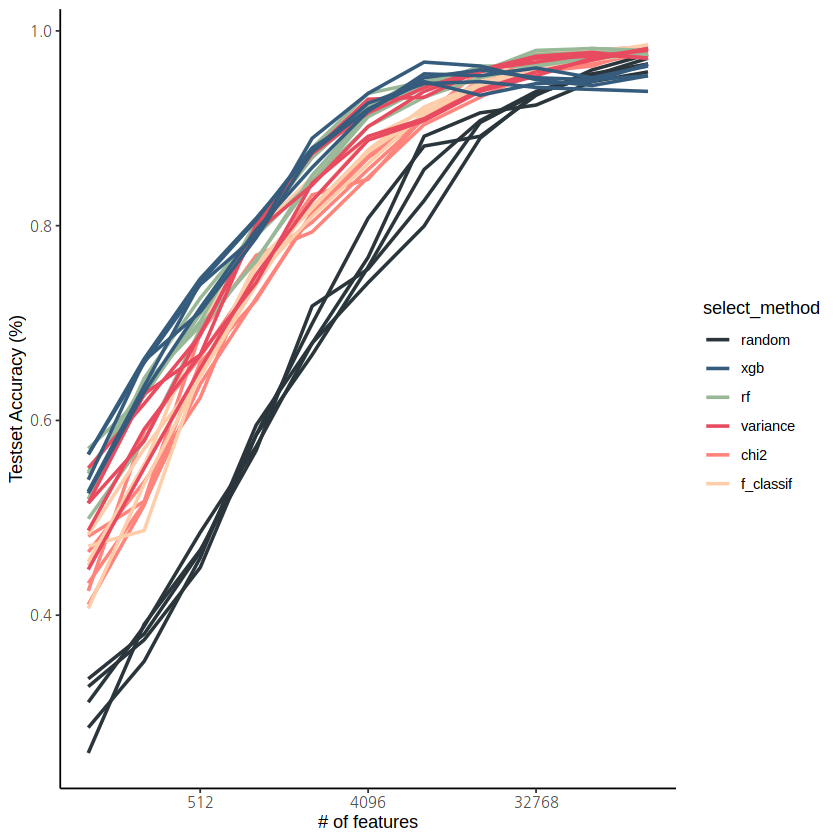

In [7]:
df_for_plot = df %>% 
  filter(train_model == "SVM", 
         pre_select_method == "random", #variance, random
         n_pre_select == 1000000,
         # n_dim_reduced == 1024,
         select_n == n_dim_reduced
        )

p = ggplot(data = df_for_plot, aes(x = select_n, y = testset_accuracy, group = plot_unit, colour = select_method)) +
  geom_line(linewidth = 1) +
  xlab("# of features") + 
  ylab("Testset Accuracy (%)") +
  scale_color_manual(values = color_map_use) +
  scale_x_continuous(trans='log2') +
  #scale_y_continuous(limits = c(0,1)) +
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")); 
        print(p)

`summarise()` has grouped output by 'pre_select_method', 'n_pre_select',
'n_pre_select_goal', 'select_n'. You can override using the `.groups` argument.


pre_select_method,n_pre_select,n_pre_select_goal,select_n,select_method,sd,sem,target_val,n
<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<int>
random,1e+06,1e+06,128,random,0.03138036,0.014033725,0.3030058,5
random,1e+06,1e+06,128,xgb,0.01976761,0.008840343,0.5442884,5
random,1e+06,1e+06,128,rf,0.02782603,0.012444178,0.5362724,5
random,1e+06,1e+06,128,variance,0.03875552,0.017331993,0.5030060,5
random,1e+06,1e+06,128,chi2,0.02910978,0.013018290,0.4428860,5
random,1e+06,1e+06,128,f_classif,0.02898535,0.012962643,0.4533068,5


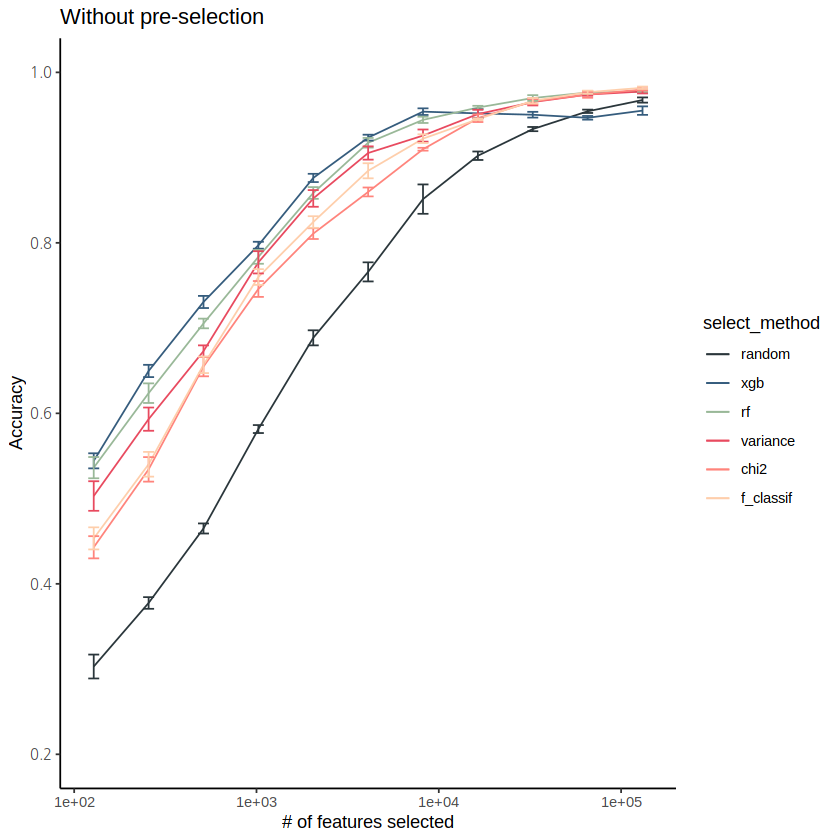

In [8]:
df_for_plot_summary = df_for_plot %>%
  group_by(pre_select_method, n_pre_select,	n_pre_select_goal, select_n, select_method) %>%
  mutate(target_val = testset_accuracy) %>%
  # mutate(target_val = testset_f1_macro) %>%
  summarise(
    sd = sd(target_val),
    sem = sd(target_val)/ sqrt(n()),
    target_val = mean(target_val),
    n = n()
  )
df_for_plot_summary %>% head()


p = ggplot(data = df_for_plot, aes(x = select_n, y = target_val, colour = select_method)) +
  # geom_jitter(position = position_jitter(0.2)) + 
  geom_line(aes(group = select_method),data = df_for_plot_summary) +
  geom_errorbar(aes(ymin = target_val-sem, ymax = target_val+sem), data = df_for_plot_summary, width = 0.2)+
  ggtitle("Without pre-selection") +
  xlab("# of features selected") + 
  ylab("Accuracy") +
  # ylab("Macro F1 score") +
  scale_color_manual(values = color_map_use) +
  scale_x_continuous(trans='log2', breaks = c(100, 1000, 10000, 100000)) +
  scale_y_continuous(limits = c(0.2,1)) +
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")); 
print(p)

ggsave("results/fig2_accuracy_by_select_n.pdf", width=12, height=9, units = c("cm"), dpi = 300)

In [9]:
df %>% 
  filter(train_model == "SVM", 
         pre_select_method == "variance",
         n_pre_select == 1000000,
         # n_dim_reduced == 1024,
         select_n == n_dim_reduced,
         select_n <= 8192,
        ) %>%
  group_by(pre_select_method, n_pre_select,	n_pre_select_goal, select_method) %>%
  summarise(
    sd = sd(testset_accuracy),
    sem = sd(testset_accuracy)/ sqrt(n()),
    testset_accuracy = mean(testset_accuracy),
    n = n()
  ) %>% arrange(-testset_accuracy)


`summarise()` has grouped output by 'pre_select_method', 'n_pre_select',
'n_pre_select_goal'. You can override using the `.groups` argument.


pre_select_method,n_pre_select,n_pre_select_goal,select_method,sd,sem,testset_accuracy,n
<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<int>
variance,1e+06,1e+06,xgb,0.004344568,0.001942950,0.9515032,5
variance,1e+06,1e+06,random,0.007551651,0.003377201,0.9422848,5
variance,1e+06,1e+06,rf,0.012385952,0.005539166,0.9342688,5
variance,1e+06,1e+06,variance,0.024404409,0.010913983,0.7767534,5
variance,1e+06,1e+06,chi2,0.022849116,0.010218435,0.7655310,5
variance,1e+06,1e+06,f_classif,0.013095185,0.005856345,0.7599198,5


In [11]:
df %>% 
  filter(train_model == "SVM", 
        #  pre_select_method == "variance",
         n_pre_select == 1000000,
         # n_dim_reduced == 1024,
         select_n == n_dim_reduced,
         select_n == 128,
        ) %>%
  group_by(pre_select_method, n_pre_select,	n_pre_select_goal, select_n, select_method) %>%
  summarise(
    sd = sd(testset_accuracy),
    sem = sd(testset_accuracy)/ sqrt(n()),
    testset_accuracy = mean(testset_accuracy),
    n = n()
  ) %>% arrange(-testset_accuracy)


`summarise()` has grouped output by 'pre_select_method', 'n_pre_select',
'n_pre_select_goal', 'select_n'. You can override using the `.groups` argument.


pre_select_method,n_pre_select,n_pre_select_goal,select_n,select_method,sd,sem,testset_accuracy,n
<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<int>
variance,1e+06,1e+06,128,xgb,0.01939886,0.008675436,0.6108214,5
random,1e+06,1e+06,128,xgb,0.01976761,0.008840343,0.5442884,5
random,1e+06,1e+06,128,rf,0.02782603,0.012444178,0.5362724,5
variance,1e+06,1e+06,128,rf,0.01137171,0.005085582,0.5206412,5
variance,1e+06,1e+06,128,random,0.01855189,0.008296657,0.5186372,5
random,1e+06,1e+06,128,variance,0.03875552,0.017331993,0.5030060,5
random,1e+06,1e+06,128,f_classif,0.02898535,0.012962643,0.4533068,5
random,1e+06,1e+06,128,chi2,0.02910978,0.013018290,0.4428860,5
variance,1e+06,1e+06,128,variance,0.01309552,0.005856496,0.3631260,5


# Figure 2 bar plot

`summarise()` has grouped output by 'pre_select_method', 'n_pre_select',
'n_pre_select_goal'. You can override using the `.groups` argument.


pre_select_method,n_pre_select,n_pre_select_goal,select_method,sd,sem,testset_accuracy,n
<chr>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<int>
random,1e+06,1e+06,random,0.1932769,0.03266976,0.5761237,35
random,1e+06,1e+06,xgb,0.1415737,0.02393033,0.7821931,35
random,1e+06,1e+06,rf,0.1446095,0.02444346,0.7670198,35
random,1e+06,1e+06,variance,0.1540404,0.02603758,0.7470943,35
random,1e+06,1e+06,chi2,0.1634655,0.02763071,0.7083309,35
random,1e+06,1e+06,f_classif,0.1674751,0.02830845,0.7202406,35


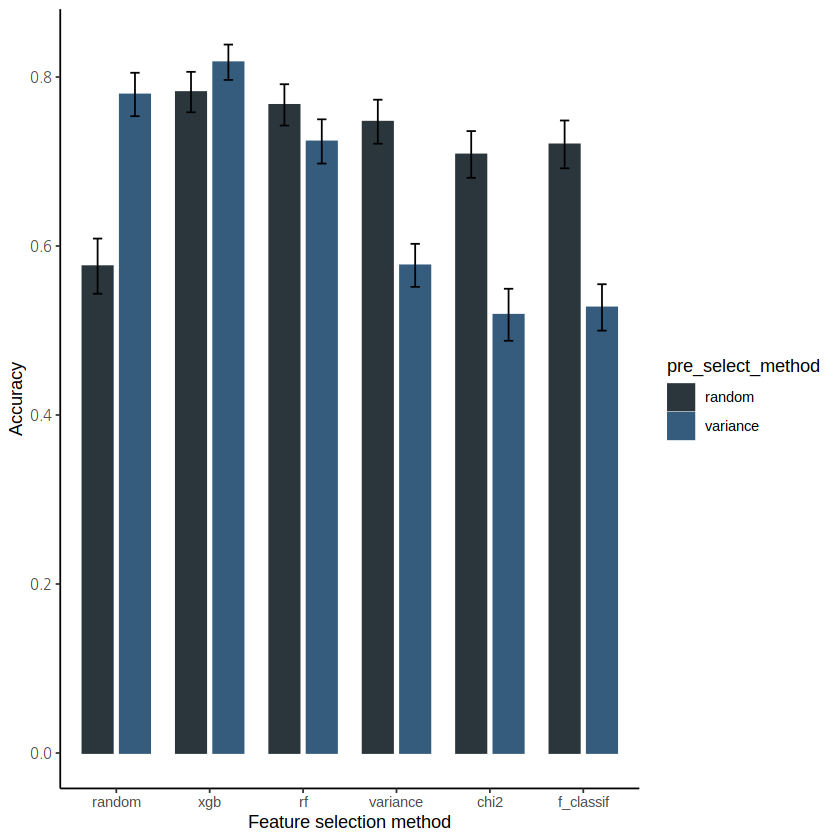

In [34]:
df_for_plot = df %>% 
  filter(train_model == "SVM", 
         pre_select_method %in% c("random", "variance"),
         n_pre_select == 1000000,
         select_n == n_dim_reduced,
         select_n <= 8192
        )

df_for_plot_summary = df_for_plot %>%
  group_by(pre_select_method, n_pre_select,	n_pre_select_goal, select_method) %>%
  summarise(
    sd = sd(testset_accuracy),
    sem = sd(testset_accuracy)/ sqrt(n()),
    testset_accuracy = mean(testset_accuracy),
    n = n()
  )

df_for_plot_summary %>% head()

p = ggplot(data = df_for_plot, aes(x = select_method, y = testset_accuracy, colour = pre_select_method, fill = pre_select_method)) +
  geom_col(data = df_for_plot_summary, position = position_dodge(0.8), width = 0.65) +
  # geom_jitter(position = position_jitterdodge(jitter.width = 0.2, dodge.width = 0.8), colour = "black") + 
  geom_errorbar(aes(ymin = testset_accuracy-sem, ymax = testset_accuracy+sem), data = df_for_plot_summary, width = 0.2, position = position_dodge(0.8), colour = "black")+
  # ggtitle("After pre-selection") +
  xlab("Feature selection method") + 
  ylab("Accuracy") +
  scale_color_manual(values = color_map_use) +
  scale_fill_manual(values = color_map_use) +
  # scale_x_continuous(trans='log2', breaks = c(100, 1000, 10000, 100000)) +
  # scale_y_continuous(limits = c(0,1)) +
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")); 
print(p)

ggsave("results/fig2_barplot.pdf", width=14, height=9, units = c("cm"), dpi = 300)

# Fig2. By n_pre_select

`summarise()` has grouped output by 'pre_select_method', 'n_pre_select',
'n_pre_select_goal', 'select_n'. You can override using the `.groups` argument.


pre_select_method,n_pre_select,n_pre_select_goal,select_n,select_method,sd,sem,testset_accuracy,n
<chr>,<dbl>,<dbl>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<int>
random,1e+06,1e+06,128,random,0.026911365,0.015537284,0.315297,3
random,1e+06,1e+06,128,xgb,0.007587022,0.004380369,0.530394,3
random,1e+06,1e+06,128,rf,0.014497293,0.008370016,0.554442,3
random,1e+06,1e+06,128,variance,0.032147392,0.018560305,0.517702,3
random,1e+06,1e+06,128,chi2,0.021208343,0.012244642,0.440882,3
random,1e+06,1e+06,128,f_classif,0.016198139,0.009352000,0.468270,3


`geom_line()`: Each group consists of only one observation.
ℹ Do you need to adjust the group aesthetic?


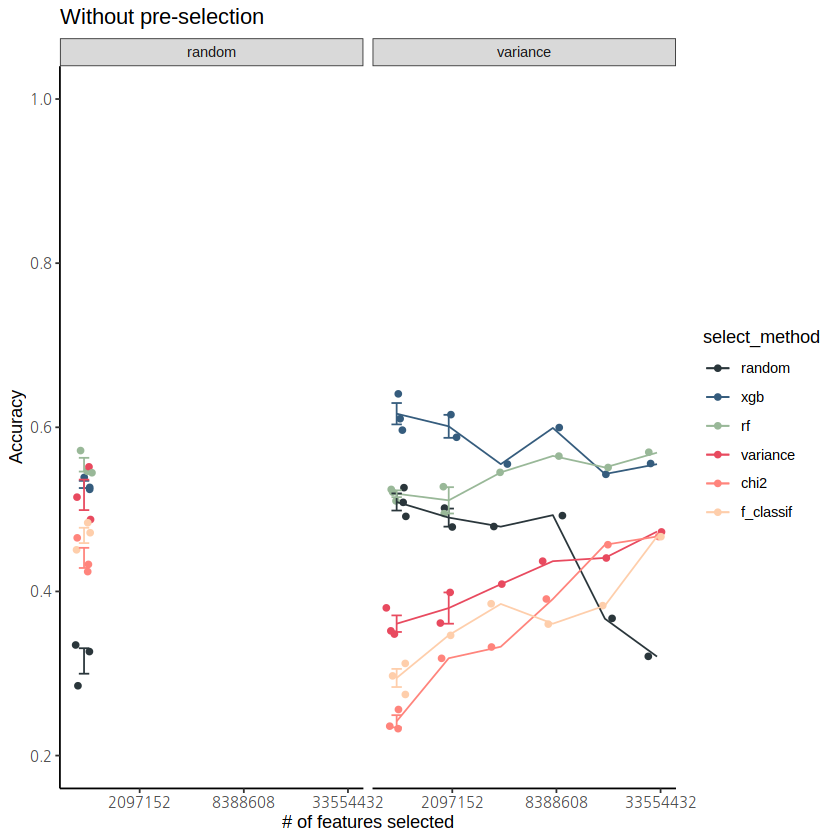

In [10]:
df_for_plot = df %>% 
  filter(train_model == "SVM", 
         pre_select_method %in% c("random", "variance"),
         select_n == n_dim_reduced,
         select_n == 128
        )

df_for_plot_summary = df_for_plot %>%
  group_by(pre_select_method, n_pre_select,	n_pre_select_goal, select_n, select_method) %>%
  summarise(
    sd = sd(testset_accuracy),
    sem = sd(testset_accuracy)/ sqrt(n()),
    testset_accuracy = mean(testset_accuracy),
    n = n()
  )

df_for_plot_summary %>% head()

p = ggplot(data = df_for_plot, aes(x = n_pre_select, y = testset_accuracy, colour = select_method)) +
  geom_jitter(position = position_jitter(0.2)) + 
  geom_line(aes(group = select_method),data = df_for_plot_summary) +
  geom_errorbar(aes(ymin = testset_accuracy-sem, ymax = testset_accuracy+sem), data = df_for_plot_summary, width = 0.2)+
  ggtitle("Without pre-selection") +
  xlab("# of features selected") + 
  ylab("Accuracy") +
  scale_color_manual(values = color_map_use) +
  scale_x_continuous(trans='log2') + # breaks = c(100, 1000, 10000, 100000, 1e6, 1e7, 1e8)
  scale_y_continuous(limits = c(0.2,1)) +
  facet_grid(cols = vars(pre_select_method)) + 
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")); 
print(p)


# ggsave("results/fig2_barplot.pdf", width=14, height=9, units = c("cm"), dpi = 300)

# resource tables

In [80]:
df %>% 
    filter(select_n %in% c(8192, 131072), n_dim_reduced == select_n, random_seed == 42) %>%
    select(random_seed, select_method, starts_with("select"), starts_with("train_")) %>%
    arrange(select_n, select_method)

random_seed,select_method,select_n,select_cpu_time,select_wall_time,select_memory_usage,train_model,train_cpu_time,train_wall_time,train_memory_usage
<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>
42,random,8192,0.004075,0.004182,2.914680,SVM,2.444804,2.445049,3.170338
42,xgb,8192,1601.559000,332.274400,36.265650,SVM,2.460954,2.461739,7.294247
42,rf,8192,2.055613,2.055789,12.464420,SVM,2.263798,2.264023,3.967911
42,variance,8192,0.105517,0.105773,23.055990,SVM,1.909399,1.909703,3.827423
42,chi2,8192,0.166361,0.116532,26.018830,SVM,1.836784,1.837281,4.337254
42,f_classif,8192,0.081738,0.082071,17.484860,SVM,1.867006,1.867519,4.841389
42,random,131072,0.062065,0.062217,3.844978,SVM,90.384630,90.389910,6.876171
42,xgb,131072,1601.559000,332.274400,36.265650,SVM,91.017070,91.022280,10.539590
42,rf,131072,2.055613,2.055789,12.464420,SVM,92.183220,92.186990,7.514378


# hybrid feature selection

In [12]:
df_hyb = read_excel("/home/jinhyun/codes/geography_prediction/results/Geography prediction experiments.xlsx", sheet = "results_hyb") %>%
    mutate(plot_unit = interaction(n_original, pre_selection, random_seed, select_method),
        #    select_method = factor(paste(n_original, select_method))
           ) 

In [13]:
df_for_plot = df_hyb %>% 
  filter(
         select_n == 256,
        #  select_method == "xgb", 
         pre_selection != 4000000
        ) %>%
  mutate(select_cpu_time = select_cpu_time / 60)


`summarise()` has grouped output by 'pre_selection', 'select_n'. You can
override using the `.groups` argument.


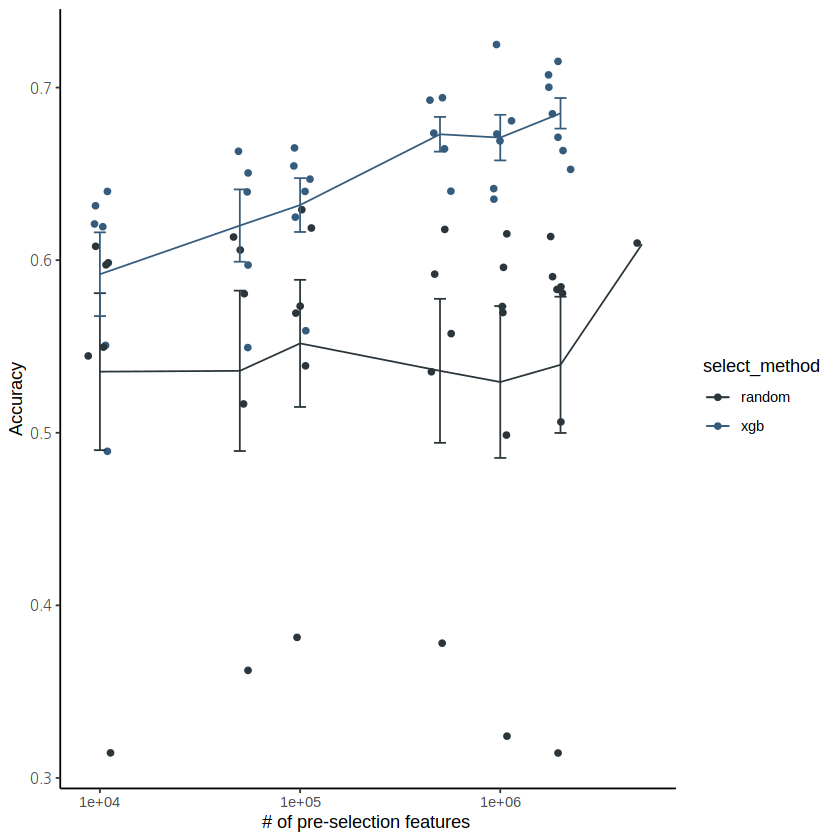

In [14]:
df_for_plot_summary = df_for_plot %>%
  group_by(pre_selection, select_n, select_method) %>%
  summarise(
    sd = sd(testset_accuracy),
    sem = sd(testset_accuracy)/ sqrt(n()),
    testset_accuracy = mean(testset_accuracy),
    n = n()
)

p = ggplot(data = df_for_plot, aes(x = pre_selection, y = testset_accuracy, colour = select_method)) +
  geom_jitter(position = position_jitter(0.2)) + 
  geom_line(aes(group = select_method),data = df_for_plot_summary) +
  geom_errorbar(aes(ymin = testset_accuracy-sem, ymax = testset_accuracy+sem), data = df_for_plot_summary, width = 0.2)+
  xlab("# of pre-selection features ") + 
  ylab("Accuracy") +
  scale_color_manual(values = color_map_use) +
  scale_x_continuous(trans='log2', breaks = c(100, 1000, 10000, 100000, 1e6)) +
  #scale_y_continuous(limits = c(0,1)) +
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")); 
print(p)

`summarise()` has grouped output by 'pre_selection', 'select_n'. You can
override using the `.groups` argument.


pre_selection,select_n,select_method,sd,sem,select_cpu_time,n
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
1e+04,256,random,1.085771e-04,4.432642e-05,9.877778e-05,6
1e+04,256,xgb,1.633052e+00,6.666907e-01,4.897734e+00,6
5e+04,256,random,8.018922e-06,3.586171e-06,9.240333e-05,5
5e+04,256,xgb,1.069151e+01,4.781388e+00,2.797682e+01,5
1e+05,256,random,3.950751e-05,1.612887e-05,1.048917e-04,6
1e+05,256,xgb,1.318114e+01,5.381178e+00,3.664212e+01,6


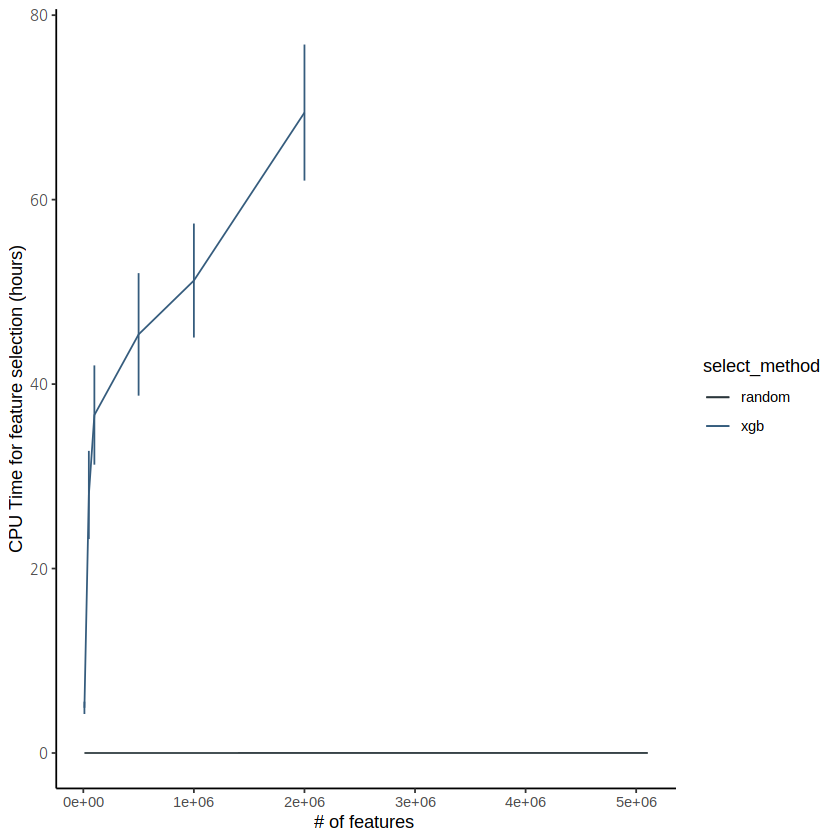

In [25]:
df_for_plot_summary = df_for_plot %>%
  group_by(pre_selection, select_n, select_method) %>%
  summarise(
    sd = sd(select_cpu_time),
    sem = sd(select_cpu_time)/ sqrt(n()),
    select_cpu_time = mean(select_cpu_time),
    n = n()
)
df_for_plot_summary %>% head

p = ggplot(data = df_for_plot, aes(x = pre_selection, y = select_cpu_time, colour = select_method)) +
  # geom_jitter(position = position_jitter(0.2)) + 
  geom_line(aes(group = select_method),data = df_for_plot_summary) +
  geom_errorbar(aes(ymin = select_cpu_time-sem, ymax = select_cpu_time+sem), data = df_for_plot_summary, width = 0.2)+
  xlab("# of features ") + 
  ylab("CPU Time for feature selection (hours)") +
  scale_color_manual(values = color_map_use) +
  # scale_x_continuous(trans='log2', breaks = c(100, 1000, 10000, 100000, 1e6)) +
  #scale_y_continuous(limits = c(0,1)) +
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")); 
print(p)

ggsave("results/fig2_CPU_time.pdf", width=12, height=9, units = c("cm"), dpi = 300)

`summarise()` has grouped output by 'pre_selection', 'select_n'. You can
override using the `.groups` argument.


pre_selection,select_n,select_method,sd,sem,select_memory_usage,n
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
1e+04,256,random,14.5305617,5.9320770,9.582668,6
1e+04,256,xgb,14.8922305,6.0797276,9.681114,6
5e+04,256,random,0.8955804,0.4005158,1.772478,5
5e+04,256,xgb,0.6775882,0.3030266,2.635592,5
1e+05,256,random,13.2140204,5.3946012,12.195113,6
1e+05,256,xgb,13.6541895,5.5742995,14.132854,6


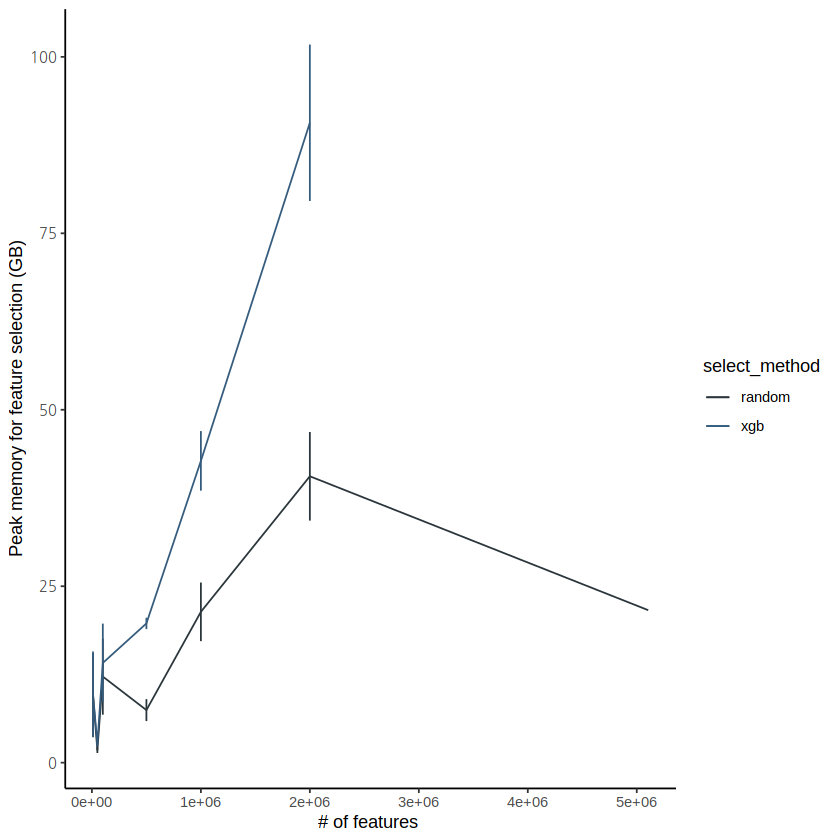

In [26]:
df_for_plot_summary = df_for_plot %>%
  group_by(pre_selection, select_n, select_method) %>%
  summarise(
    sd = sd(select_memory_usage),
    sem = sd(select_memory_usage)/ sqrt(n()),
    select_memory_usage = mean(select_memory_usage),
    n = n()
)
 df_for_plot_summary %>% head

p = ggplot(data = df_for_plot, aes(x = pre_selection, y = select_memory_usage, colour = select_method)) +
  # geom_jitter(position = position_jitter(0.2)) + 
  geom_line(aes(group = select_method),data = df_for_plot_summary) +
  geom_errorbar(aes(ymin = select_memory_usage-sem, ymax = select_memory_usage+sem), data = df_for_plot_summary, width = 0.2)+
  xlab("# of features ") + 
  ylab("Peak memory for feature selection (GB)") +
  scale_color_manual(values = color_map_use) +
  # scale_x_continuous(trans='log2', breaks = c(100, 1000, 10000, 100000, 1e6)) +
  #scale_y_continuous(limits = c(0,1)) +
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")); 
print(p)

ggsave("results/fig2_mem.pdf", width=12, height=9, units = c("cm"), dpi = 300)

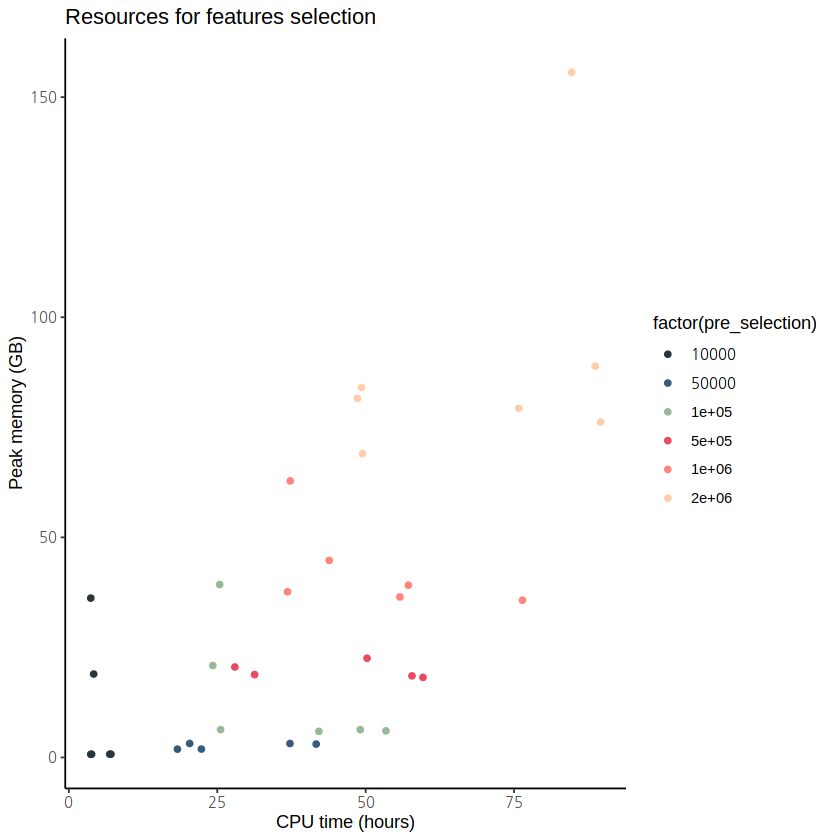

In [17]:

p = ggplot(data = df_for_plot %>% filter(select_method  == "xgb"), aes(x = select_cpu_time, y = select_memory_usage, colour = factor(pre_selection))) +
  # geom_jitter(position = position_jitter(0.2)) + 
  geom_point() + 
#   geom_line(aes(group = select_method),data = df_for_plot_summary) +
#   geom_errorbar(aes(ymin = select_memory_usage-sem, ymax = select_memory_usage+sem), data = df_for_plot_summary, width = 0.2)+
  ggtitle("Resources for features selection") +
  xlab("CPU time (hours)") + 
  ylab("Peak memory (GB)") +
  scale_color_manual(values = color_map_use) +
  # scale_x_continuous(trans='log2', breaks = c(100, 1000, 10000, 100000, 1e6)) +
  #scale_y_continuous(limits = c(0,1)) +
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")); 
print(p)
ggsave("results/fig2_resources.pdf", width=12, height=9, units = c("cm"), dpi = 300)

In [29]:
df_for_plot_summary = df_for_plot %>% filter(select_method == "xgb") %>%
  group_by(pre_selection, select_n, select_method) %>%
  summarise(
    sd = sd(select_cpu_time),
    sem = sd(select_cpu_time)/ sqrt(n()),
    select_cpu_time = mean(select_cpu_time),
    n = n()
)
df_for_plot_summary
# lr_model = lm(pre_selection ~ select_memory_usage, data = df_for_plot_summary)
# summary(lr_model)
# plot(df_for_plot_summary$pre_selection, df_for_plot_summary$select_memory_usage, pch = 16, col = "blue") #Plot the results
# abline(lr_model)
# predict(lr_model)

`summarise()` has grouped output by 'pre_selection', 'select_n'. You can
override using the `.groups` argument.


pre_selection,select_n,select_method,sd,sem,select_cpu_time,n
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<int>
1e+04,256,xgb,1.633052,0.6666907,4.897734,6
5e+04,256,xgb,10.691508,4.7813879,27.976817,5
1e+05,256,xgb,13.181140,5.3811778,36.642117,6
5e+05,256,xgb,14.859396,6.6453240,45.388150,5
1e+06,256,xgb,15.137305,6.1797788,51.226311,6
2e+06,256,xgb,19.515191,7.3760491,69.438721,7


# Fig 3a

In [10]:
df_fig4 = read_excel("/home/jinhyun/codes/geography_prediction/results/Geography prediction experiments.xlsx", sheet = "from_43M_cls")

In [11]:
colnames(df_fig4)

[1] "random_seed"                    "select_method"                 
 [3] "class_target"                   "select_n"                      
 [5] "n_dim_reduced"                  "train_model"                   
 [7] "hyper_params"                   "model_params"                  
 [9] "select_cpu_time"                "select_wall_time"              
[11] "select_memory_usage"            "train_cpu_time"                
[13] "train_wall_time"                "train_memory_usage"            
[15] "testset_accuracy"               "testset_f1_micro"              
[17] "testset_f1_macro"               "testset_f1_weighted"           
[19] "testset_class_others_accuracy"  "testset_class_target_accuracy" 
[21] "valset_accuracy"                "valset_f1_micro"               
[23] "valset_f1_macro"                "valset_f1_weighted"            
[25] "valset_class_others_accuracy"   "valset_class_target_accuracy"  
[27] "trainset_accuracy"              "trainset_f1_micro"             
[29] "trainset_f1_macro"              "trainset_f1_weighted"          
[31] "trainset_class_others_accuracy" "trainset_class_target_accuracy"

In [13]:
df_minimum_n_by_cls = df_fig4 %>% group_by(random_seed, class_target) %>%
    mutate(max_f1 = max(testset_f1_macro)) %>%
    filter(testset_f1_macro > (max_f1-0.02)) %>%
    select(class_target, select_n, n_dim_reduced, testset_f1_macro, max_f1) %>%
    summarise(select_n = min(select_n))
df_minimum_n_by_cls %>% write.table("results/minimum_n_by_cls.csv", sep = ",")

Adding missing grouping variables: `random_seed`
`summarise()` has grouped output by 'random_seed'. You can override using the
`.groups` argument.


# Supplementary figures

In [14]:
df_original = read_excel("/home/jinhyun/codes/geography_prediction/results/Geography prediction experiments.xlsx", sheet = "encoding_compare")

In [15]:
df_original %>% colnames

[1] "encoding"             "kernel"               "random_seed"         
 [4] "select_method"        "select_n"             "n_dim_reduced"       
 [7] "train_model"          "hyper_params"         "model_params"        
[10] "select_cpu_time"      "select_wall_time"     "select_memory_usage" 
[13] "train_cpu_time"       "train_wall_time"      "train_memory_usage"  
[16] "testset_accuracy"     "testset_f1_micro"     "testset_f1_macro"    
[19] "testset_f1_weighted"  "valset_accuracy"      "valset_f1_micro"     
[22] "valset_f1_macro"      "valset_f1_weighted"   "trainset_accuracy"   
[25] "trainset_f1_micro"    "trainset_f1_macro"    "trainset_f1_weighted"

In [16]:
df_original %>% group_by(encoding, kernel, random_seed, select_method, select_n, n_dim_reduced, train_model) %>%
    summarise(n=n()) %>% nrow

df = df_original %>% group_by(encoding, kernel, random_seed, select_method, select_n, n_dim_reduced, train_model) %>%
    filter(valset_accuracy == max(valset_accuracy)) %>%
    filter(trainset_accuracy == max(trainset_accuracy)) %>%
    filter(testset_accuracy == max(testset_accuracy)) %>%
    filter(row_number() == 1) 
df %>% nrow

`summarise()` has grouped output by 'encoding', 'kernel', 'random_seed',
'select_method', 'select_n', 'n_dim_reduced'. You can override using the
`.groups` argument.


[1] 87

[1] 87

In [17]:
df_for_plot %>% nrow

[1] 330

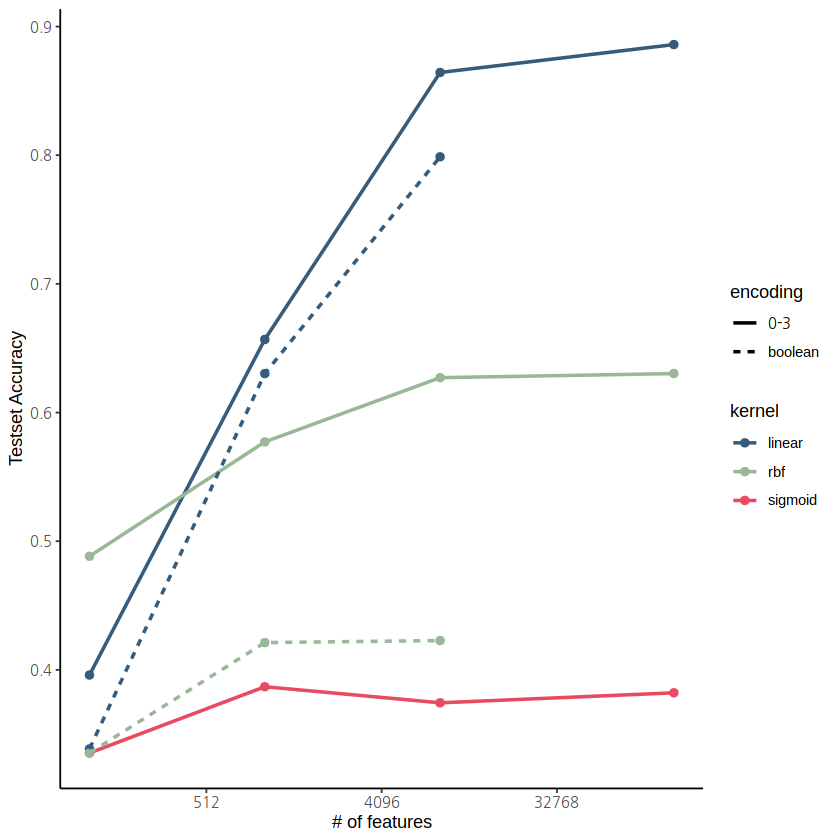

In [18]:
df_for_plot = df %>% 
  filter(train_model == "SVM", 
         select_method == "random",
         select_n == n_dim_reduced,
         !(encoding == "boolean" & kernel == "sigmoid"),
        ) %>%
  mutate(plot_unit = interaction(encoding, kernel, random_seed, select_method, train_model)) 

p = ggplot(data = df_for_plot, aes(x = select_n, y = testset_accuracy, group = plot_unit, colour = kernel)) +
  geom_point(size = 2) +
  geom_line(linewidth = 1, aes(linetype = encoding)) +
  xlab("# of features") + 
  ylab("Testset Accuracy") +
  scale_color_manual(values = color_map_use[c(2, 3, 4)]) +
  scale_x_continuous(trans='log2') +
  #scale_y_continuous(limits = c(0,1)) +
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")); 
        print(p)
  
ggsave("results/fig_supp_encoding_and_kernel.pdf", width=11, height=9, units = c("cm"), dpi = 300)

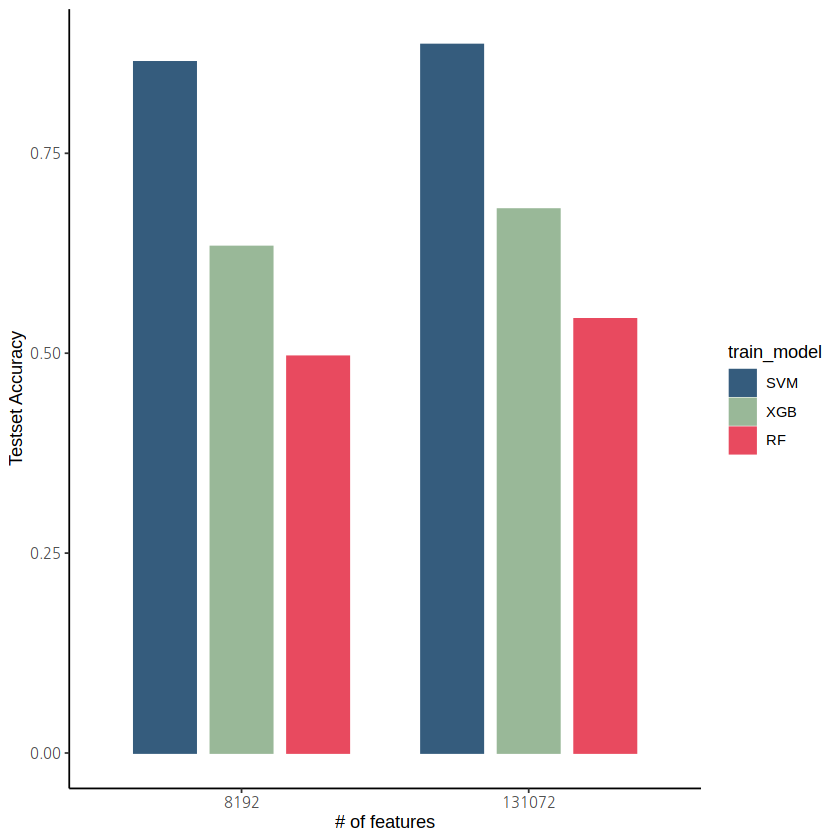

In [110]:
df_for_plot = df %>% 
  filter(encoding == "0-3",
         !(kernel %in% c("rbf", "sigmoid")),
         select_method == "random",
         select_n == n_dim_reduced,
         select_n %in% c(8192, 131072),
        ) %>%
  mutate(plot_unit = interaction(random_seed, select_method, train_model),
         train_model = factor(train_model, c("SVM", "XGB", "RF"))) 

p = ggplot(data = df_for_plot, aes(x = factor(select_n), y = testset_accuracy, colour = train_model, fill = train_model)) +
  geom_col(position = position_dodge(0.8), width = 0.65) +
#   geom_line(linewidth = 1) +
  xlab("# of features") + 
  ylab("Testset Accuracy") +
  scale_color_manual(values = color_map_use[c(2, 3, 4)]) +
  scale_fill_manual(values = color_map_use[c(2, 3, 4)]) +
  # scale_x_continuous(trans='log2') +
  #scale_y_continuous(limits = c(0,1)) +
  theme_bw() + 
  theme(panel.border = element_blank(), panel.grid.major = element_blank(),
        panel.grid.minor = element_blank(), axis.line = element_line(colour = "black")); 
        print(p)

  
ggsave("results/fig_supp_by_classifier.pdf", width=11, height=9, units = c("cm"), dpi = 300)